# Semantic Influence Networks

***Yilun Xu, MACSS Student, Division of the Social Sciences, University of Chicago***

In this part, we mainly study the following questions for tweets in three different stages: Which words are the core words in these tweets? Which words are closely related to the COVID 19 incident? Therefore, we will first construct social networks for the three data sets. Secondly, we will filter out the words that are highly relevant to the COVID 19 event and build ego-networks with nouns related to the COVID 19 event as the center.

## Import Packages

In [1]:
import lucem_illud_2020
import networkx as nx
import sklearn 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy
import nltk
from IPython.display import Image
import pickle 
import os
import random

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
random.seed(1234)

## Data Preparation

In this part, we will read all the twitter data and do basic processing on them. The tweet data we used were the tweets related to Covid19 in March. We will extract some of the columns in these datasets and calculate their sentiment scores using polarity scores based on the tweet content. After processing all the tweets, we divided them into three data sets according to the time they were generated: early, middle and late. In addition, we will also provide some functions that we will use later.

The early tweets included all tweets before March 12. The reason we chose this date as the time node is that this day is the day when Covid19 was determined to be a global pandemic. Mid-term tweets include all data from March 12 to March 20, while late tweets include all data from March 21 to March 31. In different analysis sections, we will use Early, Middle and Late to refer to the three datasets. 

In [2]:
def get_df(path):
    '''
    This function is to get the processed DataFrame of a CSV file
    with tokenized sentences and normalized sentences.
    
    Input:
    path (string): the address of a CSV file
    
    Output:
    df (DataFrame): a processed DataFrame
    '''
    df = pd.read_csv(path)
    df = df[['status_id','user_id','created_at','screen_name','text','followers_count','friends_count']]
    df['text'] = df['text'].astype(str)
    df['tokenized_sents'] = df['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
    df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])
    return df

In [3]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [4]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [5]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
def contractNetwork_all(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [6]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [7]:
t_early = get_df('slim_tweets_0125\\2020-03-00 Coronavirus Tweets (pre 2020-03-12).CSV')
t_12 = get_df('slim_tweets_0125\\2020-03-12 Coronavirus Tweets.CSV')
t_13 = get_df('slim_tweets_0125\\2020-03-13 Coronavirus Tweets.CSV')
t_14 = get_df('slim_tweets_0125\\2020-03-14 Coronavirus Tweets.CSV')
t_15 = get_df('slim_tweets_0125\\2020-03-15 Coronavirus Tweets.CSV')
t_16 = get_df('slim_tweets_0125\\2020-03-16 Coronavirus Tweets.CSV')
t_17 = get_df('slim_tweets_0125\\2020-03-17 Coronavirus Tweets.CSV')
t_18 = get_df('slim_tweets_0125\\2020-03-18 Coronavirus Tweets.CSV')
t_19 = get_df('slim_tweets_0125\\2020-03-19 Coronavirus Tweets.CSV')
t_20 = get_df('slim_tweets_0125\\2020-03-20 Coronavirus Tweets.CSV')
t_middle = pd.concat([t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20],axis=0)
t_21 = get_df('slim_tweets_0125\\2020-03-21 Coronavirus Tweets.CSV')
t_22 = get_df('slim_tweets_0125\\2020-03-22 Coronavirus Tweets.CSV')
t_23 = get_df('slim_tweets_0125\\2020-03-23 Coronavirus Tweets.CSV')
t_24 = get_df('slim_tweets_0125\\2020-03-24 Coronavirus Tweets.CSV')
t_25 = get_df('slim_tweets_0125\\2020-03-25 Coronavirus Tweets.CSV')
t_26 = get_df('slim_tweets_0125\\2020-03-26 Coronavirus Tweets.CSV')
t_27 = get_df('slim_tweets_0125\\2020-03-27 Coronavirus Tweets.CSV')
t_28 = get_df('slim_tweets_0125\\2020-03-28 Coronavirus Tweets.CSV')
t_29 = get_df('slim_tweets_0125\\2020-03-29 Coronavirus Tweets.CSV')
t_30 = get_df('slim_tweets_0125\\2020-03-30 Coronavirus Tweets.CSV')
t_31 = get_df('slim_tweets_0125\\2020-03-31 Coronavirus Tweets.CSV')
t_late = pd.concat([t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31],axis=0)
tweets = [t_early,t_middle,t_late]

## Early

### Central Words

In [8]:
g_early = wordCooccurrence(t_early['normalized_sents'].sum())

In [9]:
print('Total number of vertices: ',len(g_early.nodes))
print('Total number of edges: ', len(g_early.edges))

Total number of vertices:  15171
Total number of edges:  167010


In [10]:
bVectorizer_early = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
bVects_incidence_early = bVectorizer_early.fit_transform(t_early['text'])
bVects_incidence_early

<4144x15176 sparse matrix of type '<class 'numpy.int64'>'
	with 60880 stored elements in Compressed Sparse Row format>

In [11]:
g_early = nx.Graph()
g_early.add_nodes_from((bVectorizer_early.get_feature_names()[i] for i in range(bVects_incidence_early.shape[1])), bipartite = 'word')
g_early.add_nodes_from(range(bVects_incidence_early.shape[0]), bipartite = 'doc')
g_early.add_edges_from(((d, bVectorizer_early.get_feature_names()[w], {'weight' : bVects_incidence_early[d, w]}) 
                          for d, w in zip(*bVects_incidence_early.nonzero())))

In [12]:
print(nx.info(g_early))

Name: 
Type: Graph
Number of nodes: 19320
Number of edges: 60880
Average degree:   6.3023


In [13]:
g_word_early = contractNetwork_all(g_early, 'word')
print(nx.info(g_word_early))

Name: 
Type: Graph
Number of nodes: 15176
Number of edges: 375050
Average degree:  49.4267


In [14]:
g_word_early.remove_edges_from([(n1, n2) for n1, n2, d in g_word_early.edges(data = True) if d['weight'] <= 20])
g_word_early.remove_nodes_from(list(nx.isolates(g_word_early)))
giant_early = max(connected_component_subgraphs(g_word_early), key=len)
print(nx.info(giant_early))

Name: 
Type: Graph
Number of nodes: 351
Number of edges: 667
Average degree:   3.8006


Text(0.5, 1.0, 'Central Words in Tweets (Early)')

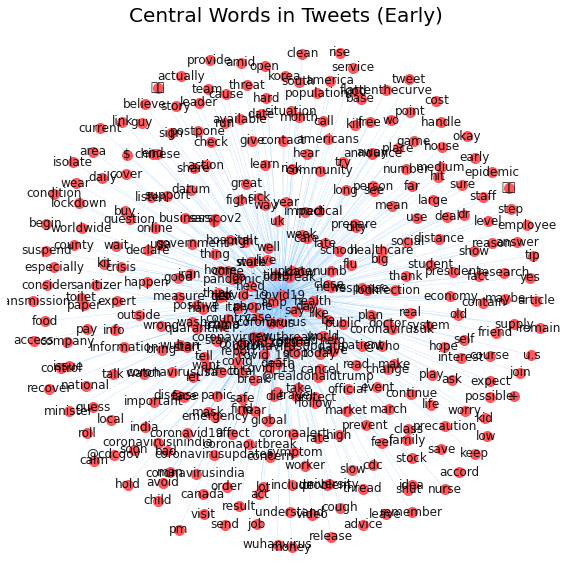

In [15]:
layout = nx.spring_layout(giant_early, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_early, ax = ax, pos = layout, labels = {n:n for n in giant_early.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')
plt.title('Central Words in Tweets (Early)', size =20)

Text(0.5, 1.0, 'Central Words in Tweets (by Degree Centrality) (Early)')

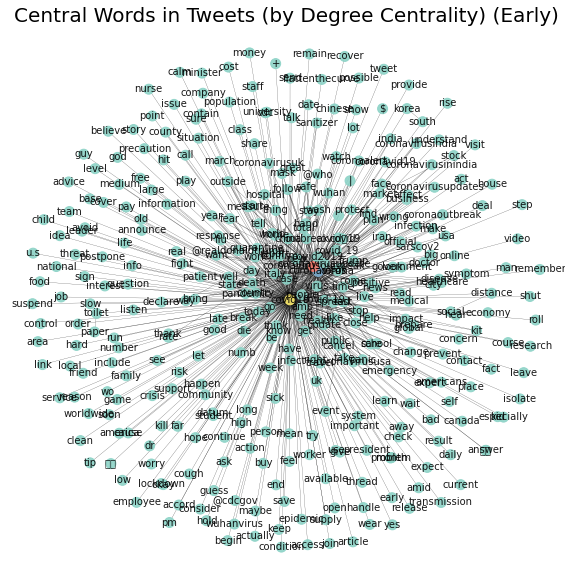

In [16]:
dcentralities_early = nx.degree_centrality(giant_early)
layout_early = nx.spring_layout(giant_early, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities_early.items(), key = lambda x : x[1])[1]
nx.draw(giant_early, ax = ax, pos = layout_early, labels = {n:n for n in giant_early.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        font_size = 10,
        node_color = [dcentralities_early[n] / maxC for n in giant_early.nodes],
        cmap = plt.get_cmap('Set3'))
plt.title('Central Words in Tweets (by Degree Centrality) (Early)', size =20)

In [17]:
sorted(dcentralities_early.items(),key = lambda x:x[1],reverse = True)

[('covid19', 0.9828571428571429),
 ('coronavirus', 0.3628571428571429),
 ('coronavirusoutbreak', 0.26),
 ('case', 0.08285714285714285),
 ('people', 0.07714285714285714),
 ('virus', 0.037142857142857144),
 ('amp', 0.02857142857142857),
 ('covid2019', 0.02857142857142857),
 ('covid_19', 0.02857142857142857),
 ('spread', 0.02857142857142857),
 ('test', 0.025714285714285714),
 ('china', 0.022857142857142857),
 ('new', 0.022857142857142857),
 ('confirm', 0.02),
 ('corona', 0.02),
 ('death', 0.02),
 ('health', 0.02),
 ('italy', 0.02),
 ('report', 0.02),
 ('total', 0.02),
 ('coronavirusupdate', 0.017142857142857144),
 ('covid', 0.017142857142857144),
 ('covidー19', 0.017142857142857144),
 ('hand', 0.017142857142857144),
 ('need', 0.017142857142857144),
 ('stop', 0.017142857142857144),
 ('country', 0.014285714285714285),
 ('home', 0.014285714285714285),
 ('like', 0.014285714285714285),
 ('live', 0.014285714285714285),
 ('positive', 0.014285714285714285),
 ('say', 0.014285714285714285),
 ('stay'

Text(0.5, 1.0, 'Central Words in Tweets (by Closeness Centrality) (Early)')

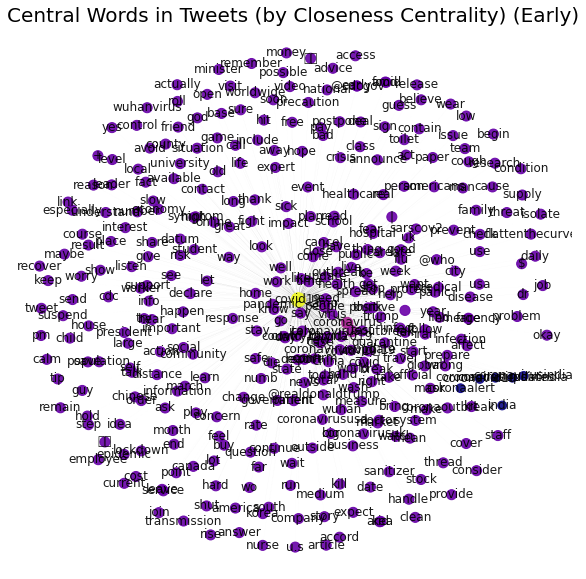

In [18]:
centralities_early = nx.closeness_centrality(giant_early)
layout_early = nx.spring_layout(giant_early, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_early.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_early.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_early.edges(data = True)))
nx.draw(giant_early, ax = ax, pos = layout_early, labels = {n:n for n in giant_early.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_early.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_early[n] / maxC for n in giant_early.nodes],
        node_size = [centralities_early[n] / maxC * 200 for n in giant_early.nodes],
        cmap = plt.get_cmap('plasma'))
plt.title('Central Words in Tweets (by Closeness Centrality) (Early)', size =20)

### Words related to "covid19"

In [19]:
covid19Neighbors = giant_early.neighbors('covid19')
g_covid19_early = giant_early.subgraph(covid19Neighbors)
print(nx.info(g_covid19_early))

Name: 
Type: Graph
Number of nodes: 344
Number of edges: 311
Average degree:   1.8081


Text(0.5, 1.0, 'All Central Words to "covid19" (Early)')

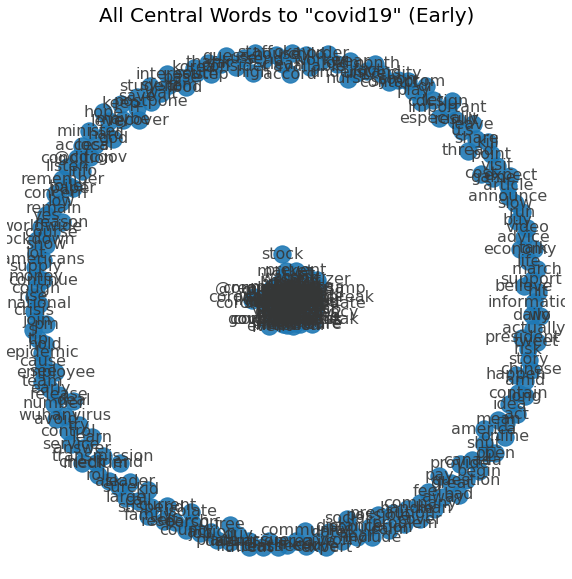

In [20]:
layout_covid19_early = nx.spring_layout(g_covid19_early, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_covid19_early.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_covid19_early.edges(data = True)))
nx.draw(g_covid19_early, ax = ax, pos = layout_covid19_early, labels = {n:n for n in g_covid19_early.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_covid19_early.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:purple',
        cmap = plt.get_cmap('plasma'))
plt.title('All Central Words to "covid19" (Early)', size =20)

In [21]:
covid19_neighbors_early = list(nx.connected_components(g_covid19_early))
group_early = []
for i in covid19_neighbors_early:
    if len(i) > len(group_early):
        group_early = list(i)
g_covid19_center_early = nx.subgraph(g_covid19_early, group_early)

Text(0.5, 1.0, 'Directly Related Central Words to "covid19" (Early)')

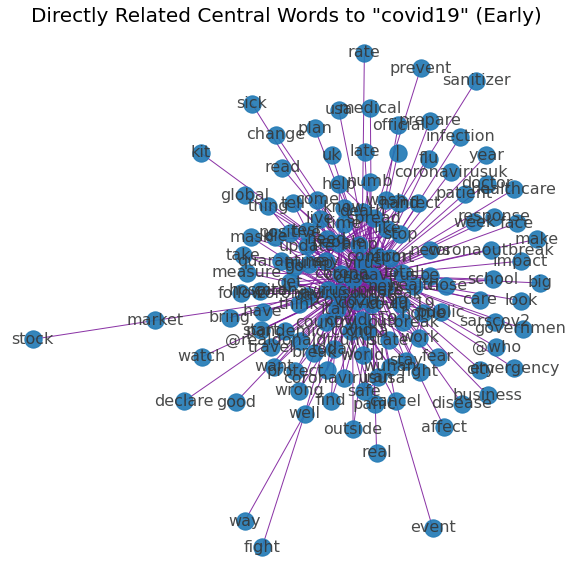

In [22]:
layout_covid19_direct_early = nx.spring_layout(g_covid19_center_early, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_covid19_center_early.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_covid19_center_early.edges(data = True)))
nx.draw(g_covid19_center_early, ax = ax, pos = layout_covid19_direct_early, labels = {n:n for n in g_covid19_center_early.nodes()}, 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:purple',
        cmap = plt.get_cmap('plasma'))
plt.title('Directly Related Central Words to "covid19" (Early)', size =20)

### "ego-networks"

#### One link away

In [23]:
gNV_early = posCooccurrence(t_early['normalized_sents'].sum(), 'NN', 'VB')
print(nx.info(gNV_early))

Name: 
Type: Graph
Number of nodes: 3699
Number of edges: 26488
Average degree:  14.3217


Let's remove:
1. co-occurrences between nouns and nouns as well as between verbs and verbs
2. low weight edges
3. low degree vertices

In [24]:
gNV_early.remove_edges_from([(n1,n2) for n1,n2,d in gNV_early.edges(data = True) 
                             if gNV_early.nodes[n1]['bipartite'] == gNV_early.nodes[n2]['bipartite']])
gNV_early.remove_edges_from([(n1, n2) for n1, n2, d in gNV_early.edges(data = True) if d['weight'] <= 2])
gNV_early.remove_nodes_from([n for n in gNV_early.nodes if len(set(gNV_early.neighbors(n))) <= 3])
print(nx.info(gNV_early))

Name: 
Type: Graph
Number of nodes: 38
Number of edges: 92
Average degree:   4.8421


Text(0.5, 1.0, 'Denser Network (Early)')

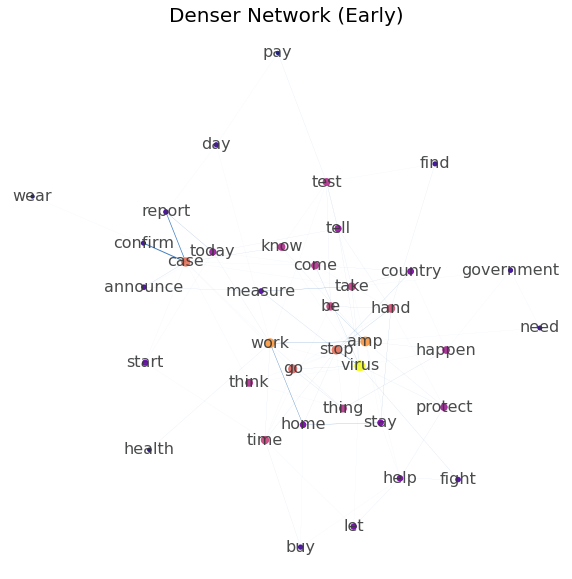

In [25]:
layout_nv_early = nx.spring_layout(gNV_early, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv_early = nx.eigenvector_centrality(gNV_early)
maxC = max(centralities_nv_early.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_early.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_early.edges(data = True)))
nx.draw(gNV_early, ax = ax, pos = layout_nv_early, labels = {n: n for n in gNV_early.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNV_early.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv_early[n] / maxC for n in gNV_early.nodes],
        node_size = [centralities_nv_early[n] / maxC * 100 for n in gNV_early.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )
plt.title('Denser Network (Early)',size = 20)

In [26]:
g_1_early = gNV_early.subgraph(['virus'] + list(gNV_early.neighbors('virus')))
print(nx.info(g_1_early))

Name: 
Type: Graph
Number of nodes: 14
Number of edges: 13
Average degree:   1.8571


Text(0.5, 1.0, 'One link Away to "virus" (Early)')

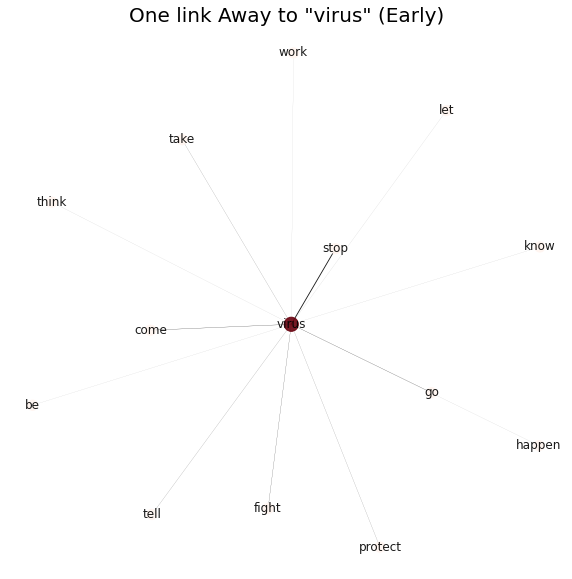

In [27]:
centralities_early_g1 = nx.closeness_centrality(g_1_early)
layout_early = nx.spring_layout(g_1_early, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_early_g1.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_1_early.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_1_early.edges(data = True)))
nx.draw(g_1_early, ax = ax, pos = layout_early, labels = {n:n for n in g_1_early.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_1_early.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_early_g1[n] / maxC for n in g_1_early.nodes],
        node_size = [centralities_early_g1[n] / maxC * 200 for n in g_1_early.nodes],
        cmap = plt.get_cmap('Reds'))
plt.title('One link Away to "virus" (Early)',size = 20)

##### Top 10 words in terms of degree centrality

In [28]:
sorted(nx.degree_centrality(g_1_early).items(), key = lambda x: x[1], reverse = True)[1:11]

[('protect', 0.07692307692307693),
 ('know', 0.07692307692307693),
 ('take', 0.07692307692307693),
 ('come', 0.07692307692307693),
 ('happen', 0.07692307692307693),
 ('go', 0.07692307692307693),
 ('think', 0.07692307692307693),
 ('let', 0.07692307692307693),
 ('tell', 0.07692307692307693),
 ('stop', 0.07692307692307693)]

#### Two links away

In [29]:
virus_nei_early = gNV_early.neighbors('virus')
virus_nei_early = set(virus_nei_early)
print(virus_nei_early)

{'protect', 'know', 'take', 'come', 'happen', 'go', 'think', 'let', 'tell', 'stop', 'fight', 'work', 'be'}


In [30]:
virus_nei_plus1_early = set(virus_nei_early)
for n in virus_nei_early:
    virus_nei_plus1_early |= set(gNV_early.neighbors(n))
gNV_virus2_early = gNV_early.subgraph(virus_nei_plus1_early)
print(nx.info(gNV_virus2_early))

Name: 
Type: Graph
Number of nodes: 28
Number of edges: 67
Average degree:   4.7857


Text(0.5, 1.0, 'Two links Away to "virus" (Early)')

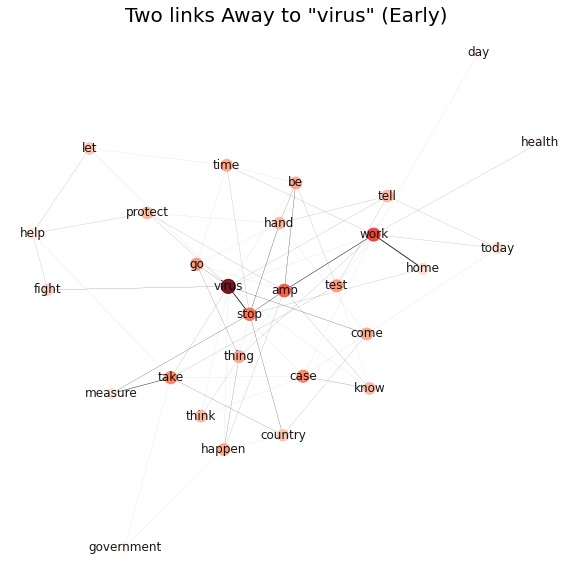

In [31]:
centralities_early_g2 = nx.closeness_centrality(gNV_virus2_early)
layout_early = nx.spring_layout(gNV_virus2_early, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_early_g2.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_virus2_early.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_virus2_early.edges(data = True)))
nx.draw(gNV_virus2_early, ax = ax, pos = layout_early, labels = {n:n for n in gNV_virus2_early.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNV_virus2_early.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_early_g2[n] / maxC for n in gNV_virus2_early.nodes],
        node_size = [centralities_early_g2[n] / maxC * 200 for n in gNV_virus2_early.nodes],
        cmap = plt.get_cmap('Reds'))
plt.title('Two links Away to "virus" (Early)',size = 20)

##### Top 10 words in terms of degree centrality

In [32]:
sorted(nx.degree_centrality(gNV_virus2_early).items(), key = lambda x: x[1], reverse = True)[1:11]

[('work', 0.37037037037037035),
 ('stop', 0.2962962962962963),
 ('amp', 0.2962962962962963),
 ('take', 0.25925925925925924),
 ('hand', 0.2222222222222222),
 ('case', 0.2222222222222222),
 ('go', 0.2222222222222222),
 ('come', 0.18518518518518517),
 ('thing', 0.18518518518518517),
 ('time', 0.18518518518518517)]

#### Three links away

In [33]:
virus_3_early = set(virus_nei_plus1_early)
for n in virus_nei_plus1_early:
    virus_3_early |= set(gNV_early.neighbors(n))
gNV_virus3_early = gNV_early.subgraph(virus_3_early)
print(nx.info(gNV_virus3_early))

Name: 
Type: Graph
Number of nodes: 38
Number of edges: 92
Average degree:   4.8421


Text(0.5, 1.0, 'Three links Away to "virus" (Early)')

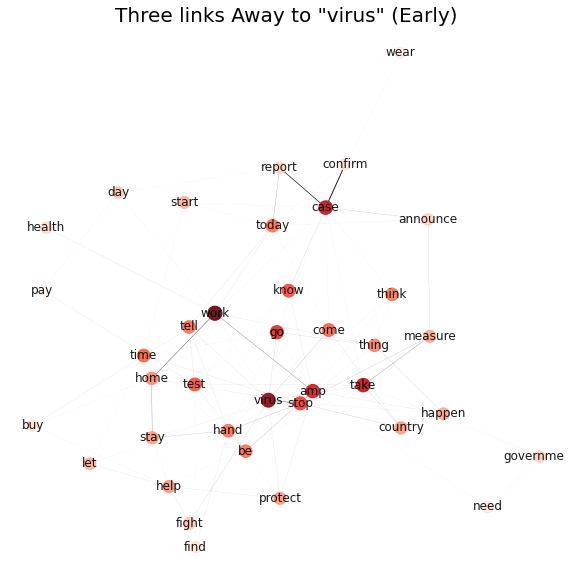

In [34]:
centralities_early_g3 = nx.closeness_centrality(gNV_virus3_early)
layout_early = nx.spring_layout(gNV_virus3_early, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_early_g3.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_virus3_early.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_virus3_early.edges(data = True)))
nx.draw(gNV_virus3_early, ax = ax, pos = layout_early, labels = {n:n for n in gNV_virus3_early.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNV_virus3_early.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_early_g3[n] / maxC for n in gNV_virus3_early.nodes],
        node_size = [centralities_early_g3[n] / maxC * 200 for n in gNV_virus3_early.nodes],
        cmap = plt.get_cmap('Reds'))
plt.title('Three links Away to "virus" (Early)',size = 20)

##### Top 10 words in terms of degree centrality

In [35]:
sorted(nx.degree_centrality(gNV_virus3_early).items(), key = lambda x: x[1], reverse = True)[1:11]

[('case', 0.2972972972972973),
 ('amp', 0.2702702702702703),
 ('work', 0.2702702702702703),
 ('hand', 0.21621621621621623),
 ('stop', 0.21621621621621623),
 ('today', 0.1891891891891892),
 ('take', 0.1891891891891892),
 ('time', 0.1891891891891892),
 ('test', 0.1891891891891892),
 ('go', 0.16216216216216217)]

## Middle

### Central Words

In [36]:
t_middle_sampled = t_middle.sample(frac = 0.1, random_state = 1234)

In [37]:
g_middle = wordCooccurrence(t_middle_sampled['normalized_sents'].sum())
print('Total number of vertices: ',len(g_middle.nodes))
print('Total number of edges: ', len(g_middle.edges))

Total number of vertices:  15227
Total number of edges:  162045


In [38]:
bVectorizer_middle = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
bVects_incidence_middle = bVectorizer_middle.fit_transform(t_middle_sampled['text'])
bVects_incidence_middle

<3856x15228 sparse matrix of type '<class 'numpy.int64'>'
	with 55671 stored elements in Compressed Sparse Row format>

In [39]:
g_middle = nx.Graph()
g_middle.add_nodes_from((bVectorizer_middle.get_feature_names()[i] for i in range(bVects_incidence_middle.shape[1])), bipartite = 'word')
g_middle.add_nodes_from(range(bVects_incidence_middle.shape[0]), bipartite = 'doc')
g_middle.add_edges_from(((d, bVectorizer_middle.get_feature_names()[w], {'weight' : bVects_incidence_middle[d, w]}) 
                          for d, w in zip(*bVects_incidence_middle.nonzero())))
print(nx.info(g_middle))

Name: 
Type: Graph
Number of nodes: 19084
Number of edges: 55671
Average degree:   5.8343


In [40]:
g_word_middle = contractNetwork_all(g_middle, 'word')
print(nx.info(g_word_middle))

Name: 
Type: Graph
Number of nodes: 15228
Number of edges: 363281
Average degree:  47.7122


In [41]:
g_word_middle.remove_edges_from([(n1, n2) for n1, n2, d in g_word_middle.edges(data = True) if d['weight'] <= 20])
g_word_middle.remove_nodes_from(list(nx.isolates(g_word_middle)))
giant_middle = max(connected_component_subgraphs(g_word_middle), key=len)
print(nx.info(giant_middle))

Name: 
Type: Graph
Number of nodes: 212
Number of edges: 411
Average degree:   3.8774


Text(0.5, 1.0, 'Central Words in Tweets (Middle)')

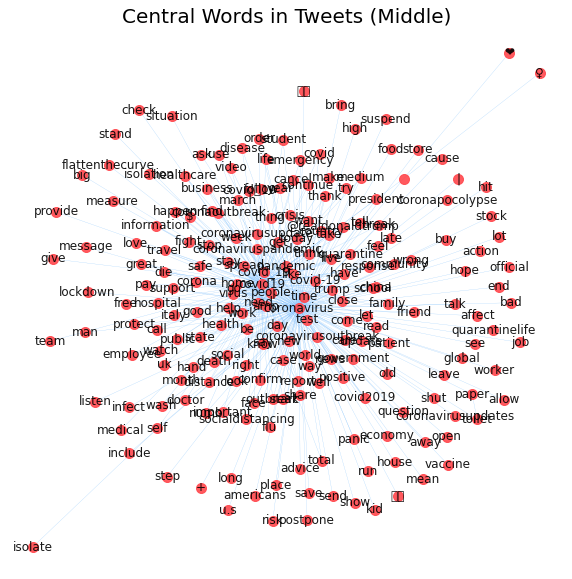

In [42]:
layout = nx.spring_layout(giant_middle, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_middle, ax = ax, pos = layout, labels = {n:n for n in giant_middle.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')
plt.title('Central Words in Tweets (Middle)', size =20)

Text(0.5, 1.0, 'Central Words in Tweets (by Degree Centrality) (Middle)')

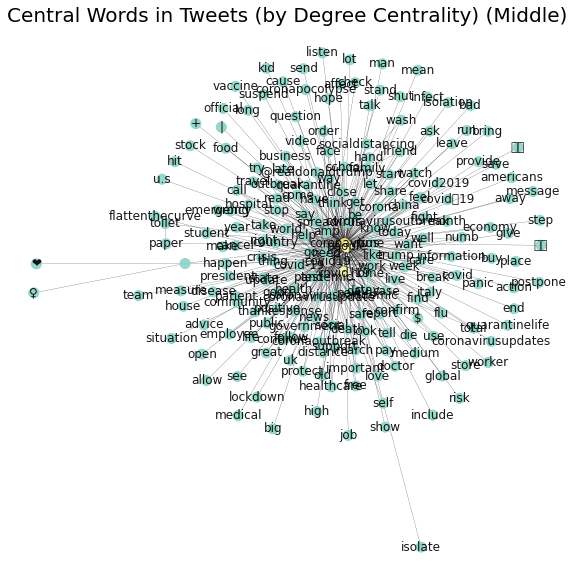

In [43]:
dcentralities_middle = nx.degree_centrality(giant_middle)
layout_middle = nx.spring_layout(giant_middle, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities_middle.items(), key = lambda x : x[1])[1]
nx.draw(giant_middle, ax = ax, pos = layout_middle, labels = {n:n for n in giant_middle.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities_middle[n] / maxC for n in giant_middle.nodes],
        cmap = plt.get_cmap('Set3'))
plt.title('Central Words in Tweets (by Degree Centrality) (Middle)', size =20)

In [44]:
sorted(dcentralities_middle.items(),key = lambda x:x[1],reverse = True)

[('coronavirus', 0.9383886255924171),
 ('covid19', 0.6682464454976303),
 ('people', 0.1090047393364929),
 ('covid_19', 0.09004739336492892),
 ('need', 0.037914691943127965),
 ('amp', 0.03317535545023697),
 ('case', 0.03317535545023697),
 ('coronaviruspandemic', 0.03317535545023697),
 ('home', 0.028436018957345974),
 ('pandemic', 0.028436018957345974),
 ('spread', 0.028436018957345974),
 ('stay', 0.028436018957345974),
 ('test', 0.028436018957345974),
 ('time', 0.028436018957345974),
 ('virus', 0.028436018957345974),
 ('coronavirusoutbreak', 0.023696682464454978),
 ('like', 0.023696682464454978),
 ('work', 0.023696682464454978),
 ('be', 0.018957345971563982),
 ('corona', 0.018957345971563982),
 ('coronavirusupdate', 0.018957345971563982),
 ('covid-19', 0.018957345971563982),
 ('day', 0.018957345971563982),
 ('go', 0.018957345971563982),
 ('help', 0.018957345971563982),
 ('new', 0.018957345971563982),
 ('report', 0.018957345971563982),
 ('️', 0.018957345971563982),
 ('close', 0.014218009

Text(0.5, 1.0, 'Central Words in Tweets (by Closeness Centrality) (Middle)')

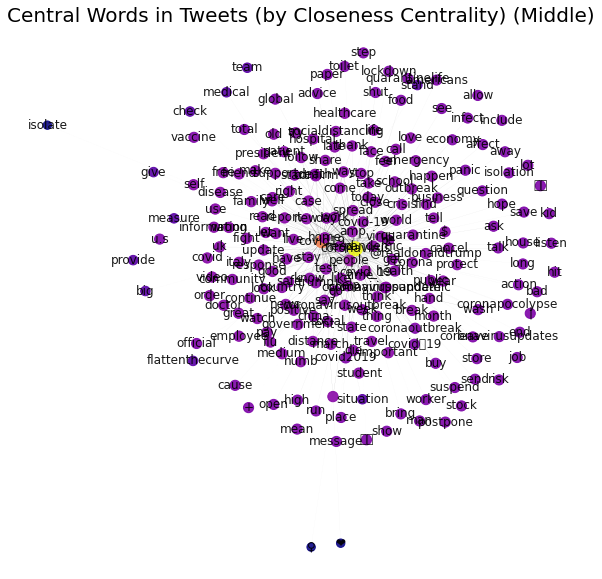

In [45]:
centralities_middle = nx.closeness_centrality(giant_middle)
layout_middle = nx.spring_layout(giant_middle, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_middle.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_middle.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_middle.edges(data = True)))
nx.draw(giant_middle, ax = ax, pos = layout_middle, labels = {n:n for n in giant_middle.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_middle.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_middle[n] / maxC for n in giant_middle.nodes],
        node_size = [centralities_middle[n] / maxC * 200 for n in giant_middle.nodes],
        cmap = plt.get_cmap('plasma'))
plt.title('Central Words in Tweets (by Closeness Centrality) (Middle)', size =20)

### Words related to "covid19"

In [46]:
covid19Neighbors = giant_middle.neighbors('covid19')
g_covid19_middle = giant_middle.subgraph(covid19Neighbors)
print(nx.info(g_covid19_middle))

Name: 
Type: Graph
Number of nodes: 141
Number of edges: 194
Average degree:   2.7518


Text(0.5, 1.0, 'All Central Words to "covid19" (Middle)')

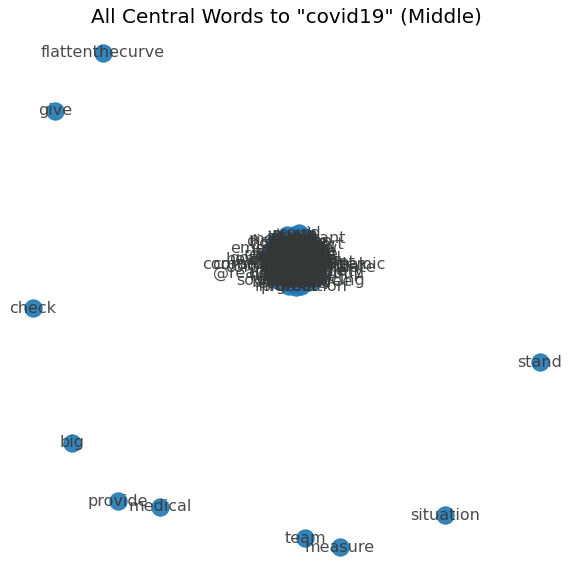

In [47]:
layout_covid19_middle = nx.spring_layout(g_covid19_middle, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_covid19_middle.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_covid19_middle.edges(data = True)))
nx.draw(g_covid19_middle, ax = ax, pos = layout_covid19_middle, labels = {n:n for n in g_covid19_middle.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_covid19_middle.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:purple',
        cmap = plt.get_cmap('plasma'))
plt.title('All Central Words to "covid19" (Middle)', size =20)

In [48]:
covid19_neighbors_middle = list(nx.connected_components(g_covid19_middle))
group_middle = []
for i in covid19_neighbors_middle:
    if len(i) > len(group_middle):
        group_middle = list(i)
g_covid19_center_middle = nx.subgraph(g_covid19_middle, group_middle)

Text(0.5, 1.0, 'Directly Related Central Words to "covid19" (Middle)')

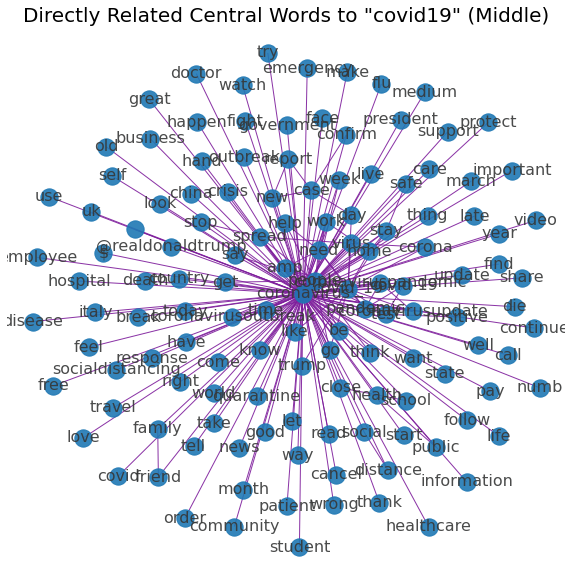

In [49]:
layout_covid19_direct_middle = nx.spring_layout(g_covid19_center_middle, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_covid19_center_middle.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_covid19_center_middle.edges(data = True)))
nx.draw(g_covid19_center_middle, ax = ax, pos = layout_covid19_direct_middle, labels = {n:n for n in g_covid19_center_middle.nodes()}, 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:purple',
        cmap = plt.get_cmap('plasma'))
plt.title('Directly Related Central Words to "covid19" (Middle)', size =20)

### "ego-networks"

#### One link away

In [50]:
gNV_middle = posCooccurrence(t_middle_sampled['normalized_sents'].sum(), 'NN', 'VB')
print(nx.info(gNV_middle))

Name: 
Type: Graph
Number of nodes: 3774
Number of edges: 26222
Average degree:  13.8961


Let's remove:
1. co-occurrences between nouns and nouns as well as between verbs and verbs
2. low weight edges
3. low degree vertices

In [51]:
gNV_middle.remove_edges_from([(n1,n2) for n1,n2,d in gNV_middle.edges(data = True) 
                             if gNV_middle.nodes[n1]['bipartite'] == gNV_middle.nodes[n2]['bipartite']])
gNV_middle.remove_edges_from([(n1, n2) for n1, n2, d in gNV_middle.edges(data = True) if d['weight'] <= 2])
gNV_middle.remove_nodes_from([n for n in gNV_middle.nodes if len(set(gNV_middle.neighbors(n))) <= 3])
print(nx.info(gNV_middle))

Name: 
Type: Graph
Number of nodes: 35
Number of edges: 82
Average degree:   4.6857


Text(0.5, 1.0, 'Denser Network (Middle)')

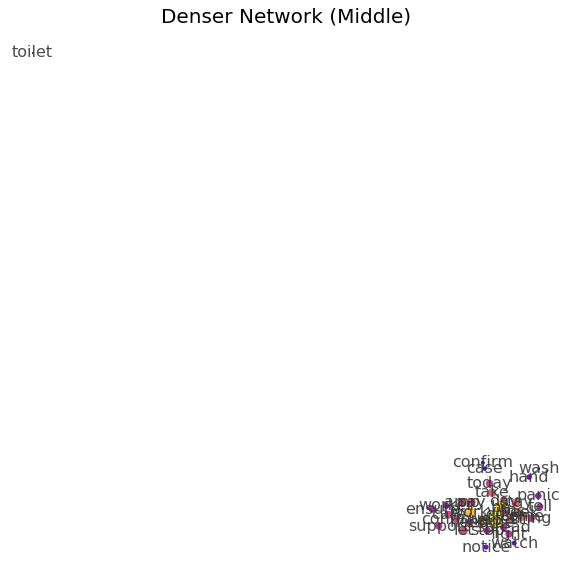

In [52]:
layout_nv_middle = nx.spring_layout(gNV_middle, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv_middle = nx.eigenvector_centrality(gNV_middle)
maxC = max(centralities_nv_middle.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_middle.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_middle.edges(data = True)))
nx.draw(gNV_middle, ax = ax, pos = layout_nv_middle, labels = {n: n for n in gNV_middle.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNV_middle.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv_middle[n] / maxC for n in gNV_middle.nodes],
        node_size = [centralities_nv_middle[n] / maxC * 100 for n in gNV_middle.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )
plt.title('Denser Network (Middle)',size = 20)

In [53]:
g_1_middle = gNV_middle.subgraph(['virus'] + list(gNV_middle.neighbors('virus')))
print(nx.info(g_1_middle))

Name: 
Type: Graph
Number of nodes: 7
Number of edges: 6
Average degree:   1.7143


Text(0.5, 1.0, 'One link Away to "virus" (Middle)')

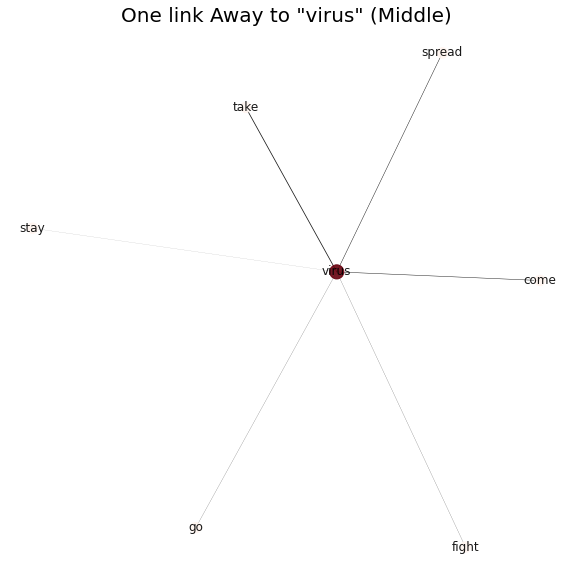

In [54]:
centralities_middle_g1 = nx.closeness_centrality(g_1_middle)
layout_middle = nx.spring_layout(g_1_middle, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_middle_g1.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_1_middle.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_1_middle.edges(data = True)))
nx.draw(g_1_middle, ax = ax, pos = layout_middle, labels = {n:n for n in g_1_middle.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_1_middle.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_middle_g1[n] / maxC for n in g_1_middle.nodes],
        node_size = [centralities_middle_g1[n] / maxC * 200 for n in g_1_middle.nodes],
        cmap = plt.get_cmap('Reds'))
plt.title('One link Away to "virus" (Middle)',size = 20)

##### Top 10 words in terms of degree centrality

In [55]:
sorted(nx.degree_centrality(g_1_middle).items(), key = lambda x: x[1], reverse = True)[1:11]

[('take', 0.16666666666666666),
 ('spread', 0.16666666666666666),
 ('come', 0.16666666666666666),
 ('go', 0.16666666666666666),
 ('stay', 0.16666666666666666),
 ('fight', 0.16666666666666666)]

#### Two links away

In [56]:
virus_nei_middle = gNV_middle.neighbors('virus')
virus_nei_middle = set(virus_nei_middle)
print(virus_nei_middle)

{'spread', 'take', 'come', 'go', 'stay', 'fight'}


In [57]:
virus_nei_plus1_middle = set(virus_nei_middle)
for n in virus_nei_middle:
    virus_nei_plus1_middle |= set(gNV_middle.neighbors(n))
gNV_virus2_middle = gNV_middle.subgraph(virus_nei_plus1_middle)
print(nx.info(gNV_virus2_middle))

Name: 
Type: Graph
Number of nodes: 20
Number of edges: 35
Average degree:   3.5000


Text(0.5, 1.0, 'Two links Away to "virus" (Middle)')

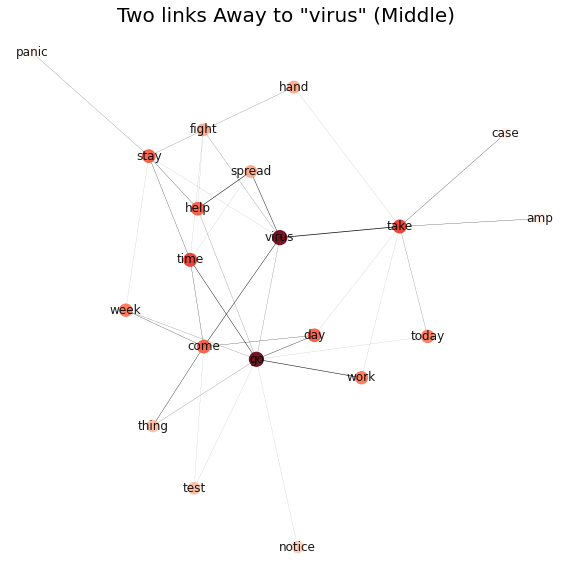

In [58]:
centralities_middle_g2 = nx.closeness_centrality(gNV_virus2_middle)
layout_middle = nx.spring_layout(gNV_virus2_middle, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_middle_g2.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_virus2_middle.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_virus2_middle.edges(data = True)))
nx.draw(gNV_virus2_middle, ax = ax, pos = layout_middle, labels = {n:n for n in gNV_virus2_middle.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNV_virus2_middle.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_middle_g2[n] / maxC for n in gNV_virus2_middle.nodes],
        node_size = [centralities_middle_g2[n] / maxC * 200 for n in gNV_virus2_middle.nodes],
        cmap = plt.get_cmap('Reds'))
plt.title('Two links Away to "virus" (Middle)',size = 20)

##### Top 10 words in terms of degree centrality

In [59]:
sorted(nx.degree_centrality(gNV_virus2_middle).items(), key = lambda x: x[1], reverse = True)[1:11]

[('take', 0.3684210526315789),
 ('come', 0.3157894736842105),
 ('virus', 0.3157894736842105),
 ('stay', 0.3157894736842105),
 ('time', 0.2631578947368421),
 ('help', 0.21052631578947367),
 ('day', 0.15789473684210525),
 ('week', 0.15789473684210525),
 ('spread', 0.15789473684210525),
 ('fight', 0.15789473684210525)]

#### Three links away

In [60]:
virus_3_middle = set(virus_nei_plus1_middle)
for n in virus_nei_plus1_middle:
    virus_3_middle |= set(gNV_middle.neighbors(n))
gNV_virus3_middle = gNV_middle.subgraph(virus_3_middle)
print(nx.info(gNV_virus3_middle))

Name: 
Type: Graph
Number of nodes: 32
Number of edges: 73
Average degree:   4.5625


Text(0.5, 1.0, 'Three links Away to "virus" (Middle)')

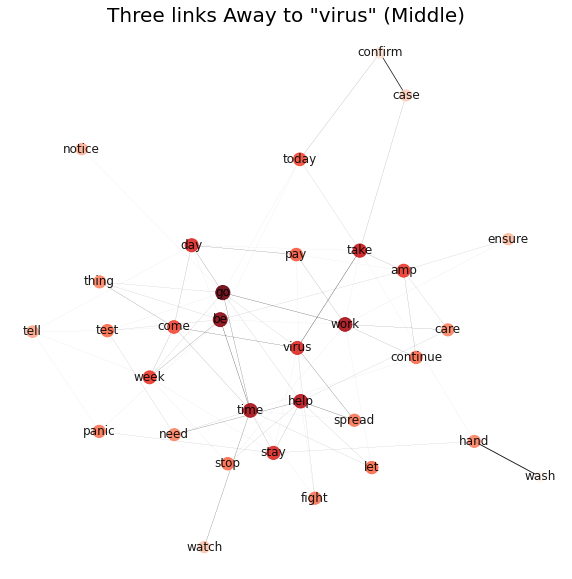

In [61]:
centralities_middle_g3 = nx.closeness_centrality(gNV_virus3_middle)
layout_middle = nx.spring_layout(gNV_virus3_middle, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_middle_g3.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_virus3_middle.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_virus3_middle.edges(data = True)))
nx.draw(gNV_virus3_middle, ax = ax, pos = layout_middle, labels = {n:n for n in gNV_virus3_middle.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNV_virus3_middle.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_middle_g3[n] / maxC for n in gNV_virus3_middle.nodes],
        node_size = [centralities_middle_g3[n] / maxC * 200 for n in gNV_virus3_middle.nodes],
        cmap = plt.get_cmap('Reds'))
plt.title('Three links Away to "virus" (Middle)',size = 20)

##### Top 10 words in terms of degree centrality

In [62]:
sorted(nx.degree_centrality(gNV_virus3_middle).items(), key = lambda x: x[1], reverse = True)[1:11]

[('time', 0.3225806451612903),
 ('help', 0.29032258064516125),
 ('work', 0.29032258064516125),
 ('be', 0.29032258064516125),
 ('take', 0.22580645161290322),
 ('day', 0.1935483870967742),
 ('come', 0.1935483870967742),
 ('virus', 0.1935483870967742),
 ('stay', 0.1935483870967742),
 ('week', 0.1935483870967742)]

## Late

### Central Words

In [63]:
t_late_sampled = t_late.sample(frac = 0.1, random_state = 1234)
g_late = wordCooccurrence(t_late_sampled['normalized_sents'].sum())
print('Total number of vertices: ',len(g_late.nodes))
print('Total number of edges: ', len(g_late.edges))

Total number of vertices:  20562
Total number of edges:  230145


In [64]:
bVectorizer_late = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
bVects_incidence_late = bVectorizer_late.fit_transform(t_late_sampled['text'])
bVects_incidence_late

<5233x20577 sparse matrix of type '<class 'numpy.int64'>'
	with 79487 stored elements in Compressed Sparse Row format>

In [65]:
g_late = nx.Graph()
g_late.add_nodes_from((bVectorizer_late.get_feature_names()[i] for i in range(bVects_incidence_late.shape[1])), bipartite = 'word')
g_late.add_nodes_from(range(bVects_incidence_late.shape[0]), bipartite = 'doc')
g_late.add_edges_from(((d, bVectorizer_late.get_feature_names()[w], {'weight' : bVects_incidence_late[d, w]}) 
                          for d, w in zip(*bVects_incidence_late.nonzero())))
print(nx.info(g_late))

Name: 
Type: Graph
Number of nodes: 25810
Number of edges: 79487
Average degree:   6.1594


In [66]:
g_word_late = contractNetwork_all(g_late, 'word')
print(nx.info(g_word_late))

Name: 
Type: Graph
Number of nodes: 20577
Number of edges: 518363
Average degree:  50.3828


In [67]:
g_word_late.remove_edges_from([(n1, n2) for n1, n2, d in g_word_late.edges(data = True) if d['weight'] <= 20])
g_word_late.remove_nodes_from(list(nx.isolates(g_word_late)))
giant_late = max(connected_component_subgraphs(g_word_late), key=len)
print(nx.info(giant_late))

Name: 
Type: Graph
Number of nodes: 323
Number of edges: 872
Average degree:   5.3994


Text(0.5, 1.0, 'Central Words in Tweets (Late)')

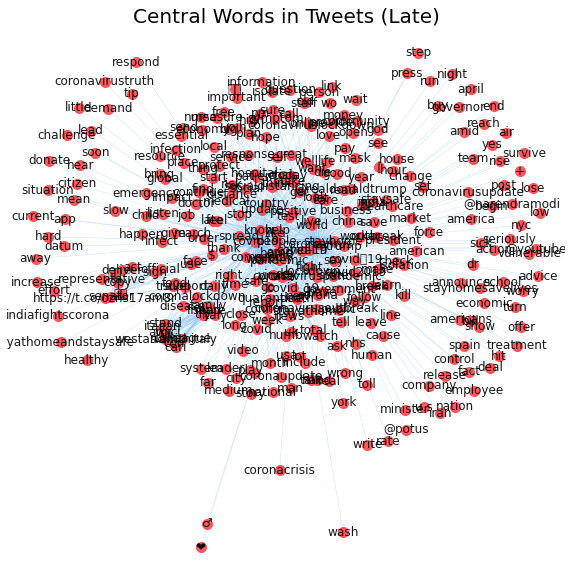

In [68]:
layout = nx.spring_layout(giant_late, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_late, ax = ax, pos = layout, labels = {n:n for n in giant_late.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')
plt.title('Central Words in Tweets (Late)', size =20)

Text(0.5, 1.0, 'Central Words in Tweets (by Degree Centrality) (Late)')

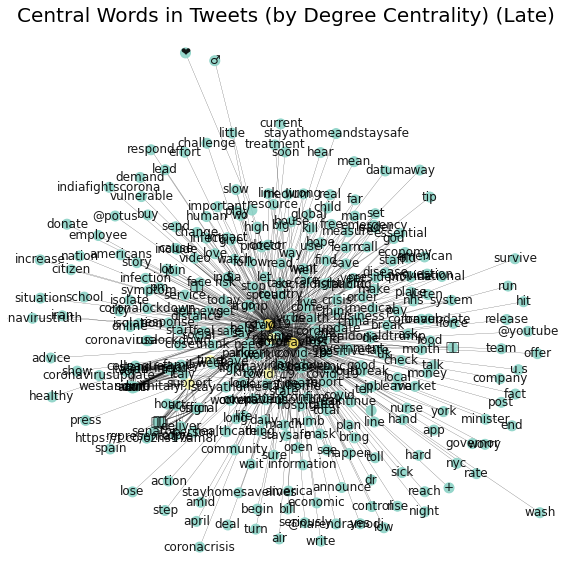

In [69]:
dcentralities_late = nx.degree_centrality(giant_late)
layout_late = nx.spring_layout(giant_late, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities_late.items(), key = lambda x : x[1])[1]
nx.draw(giant_late, ax = ax, pos = layout_late, labels = {n:n for n in giant_late.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities_late[n] / maxC for n in giant_late.nodes],
        cmap = plt.get_cmap('Set3'))
plt.title('Central Words in Tweets (by Degree Centrality) (Late)', size =20)

In [70]:
sorted(dcentralities_late.items(),key = lambda x:x[1],reverse = True)

[('coronavirus', 0.8602484472049688),
 ('covid19', 0.8043478260869564),
 ('covid_19', 0.11180124223602483),
 ('people', 0.09006211180124223),
 ('support', 0.08695652173913043),
 ('time', 0.07763975155279502),
 ('case', 0.06211180124223602),
 ('amp', 0.05590062111801242),
 ('italy', 0.05590062111801242),
 ('family', 0.05279503105590062),
 ('friend', 0.05279503105590062),
 ('home', 0.05279503105590062),
 ('share', 0.05279503105590062),
 ('try', 0.05279503105590062),
 ('amici', 0.049689440993788817),
 ('cari', 0.049689440993788817),
 ('colleague', 0.049689440993788817),
 ('con', 0.049689440993788817),
 ('italian', 0.049689440993788817),
 ('siamo', 0.049689440993788817),
 ('stand', 0.049689440993788817),
 ('voi', 0.049689440993788817),
 ('westandwithitaly', 0.049689440993788817),
 ('coronaviruspandemic', 0.046583850931677016),
 ('help', 0.043478260869565216),
 ('official', 0.037267080745341616),
 ('sign', 0.037267080745341616),
 ('act', 0.03416149068322981),
 ('copy', 0.03416149068322981),

Text(0.5, 1.0, 'Central Words in Tweets (by Closeness Centrality) (Late)')

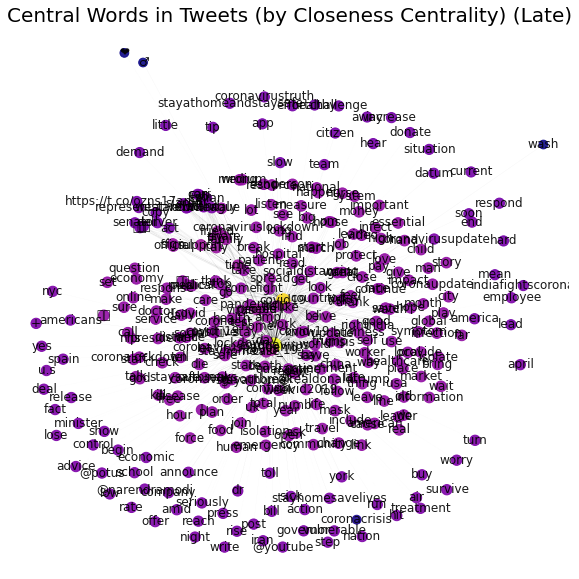

In [71]:
centralities_late = nx.closeness_centrality(giant_late)
layout_late = nx.spring_layout(giant_late, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_late.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_late.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_late.edges(data = True)))
nx.draw(giant_late, ax = ax, pos = layout_late, labels = {n:n for n in giant_late.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_late.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_late[n] / maxC for n in giant_late.nodes],
        node_size = [centralities_late[n] / maxC * 200 for n in giant_late.nodes],
        cmap = plt.get_cmap('plasma'))
plt.title('Central Words in Tweets (by Closeness Centrality) (Late)', size =20)

### Words related to "covid19"

In [72]:
covid19Neighbors = giant_late.neighbors('covid19')
g_covid19_late = giant_late.subgraph(covid19Neighbors)
print(nx.info(g_covid19_late))

Name: 
Type: Graph
Number of nodes: 259
Number of edges: 548
Average degree:   4.2317


Text(0.5, 1.0, 'All Central Words to "covid19" (Late)')

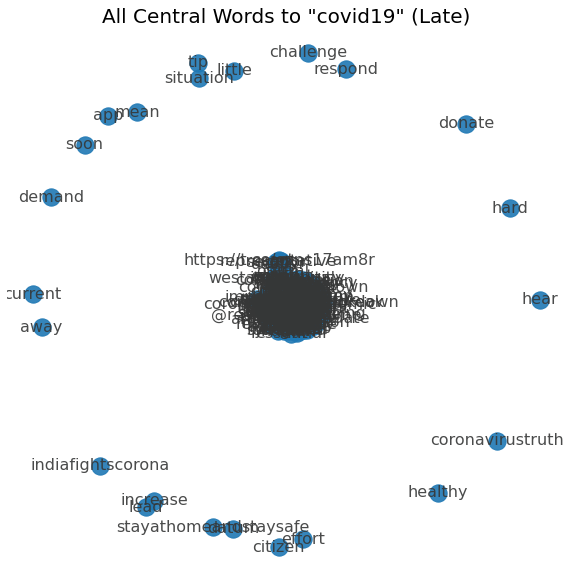

In [73]:
layout_covid19_late = nx.spring_layout(g_covid19_late, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_covid19_late.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_covid19_late.edges(data = True)))
nx.draw(g_covid19_late, ax = ax, pos = layout_covid19_late, labels = {n:n for n in g_covid19_late.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_covid19_late.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:purple',
        cmap = plt.get_cmap('plasma'))
plt.title('All Central Words to "covid19" (Late)', size =20)

In [74]:
covid19_neighbors_late = list(nx.connected_components(g_covid19_late))
group_late = []
for i in covid19_neighbors_late:
    if len(i) > len(group_late):
        group_late = list(i)
g_covid19_center_late = nx.subgraph(g_covid19_late, group_late)

Text(0.5, 1.0, 'Directly Related Central Words to "covid19" (Late)')

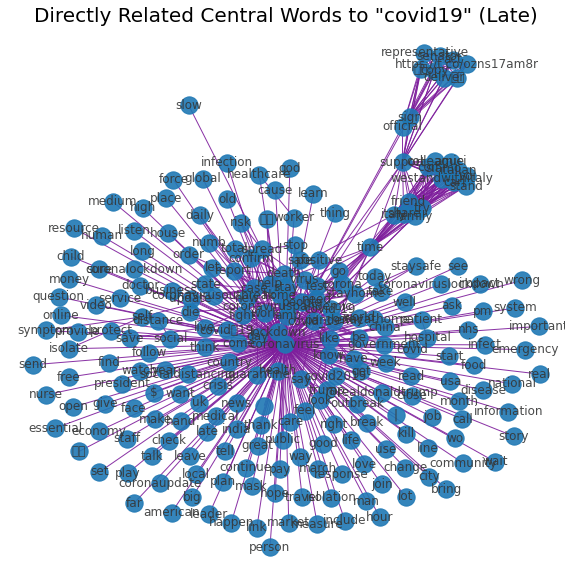

In [75]:
layout_covid19_direct_late = nx.spring_layout(g_covid19_center_late, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_covid19_center_late.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_covid19_center_late.edges(data = True)))
nx.draw(g_covid19_center_late, ax = ax, pos = layout_covid19_direct_late, labels = {n:n for n in g_covid19_center_late.nodes()}, 
        alpha = .9, 
        font_size = 12,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:purple',
        cmap = plt.get_cmap('plasma'))
plt.title('Directly Related Central Words to "covid19" (Late)', size =20)

### "ego-networks"

#### One link away

In [76]:
gNV_late = posCooccurrence(t_late_sampled['normalized_sents'].sum(), 'NN', 'VB')
print(nx.info(gNV_late))

Name: 
Type: Graph
Number of nodes: 4778
Number of edges: 36184
Average degree:  15.1461


Let's remove:
1. co-occurrences between nouns and nouns as well as between verbs and verbs
2. low weight edges
3. low degree vertices

In [77]:
gNV_late.remove_edges_from([(n1,n2) for n1,n2,d in gNV_late.edges(data = True) 
                             if gNV_late.nodes[n1]['bipartite'] == gNV_late.nodes[n2]['bipartite']])
gNV_late.remove_edges_from([(n1, n2) for n1, n2, d in gNV_late.edges(data = True) if d['weight'] <= 2])
gNV_late.remove_nodes_from([n for n in gNV_late.nodes if len(set(gNV_late.neighbors(n))) <= 3])
print(nx.info(gNV_late))

Name: 
Type: Graph
Number of nodes: 72
Number of edges: 223
Average degree:   6.1944


Text(0.5, 1.0, 'Denser Network (Late)')

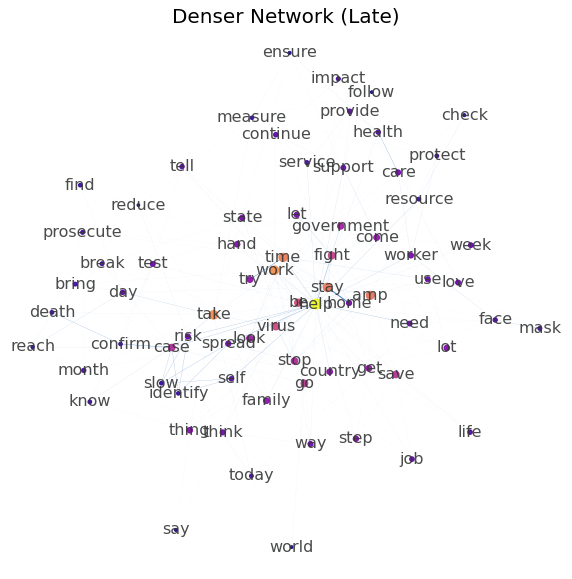

In [78]:
layout_nv_late = nx.spring_layout(gNV_late, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv_late = nx.eigenvector_centrality(gNV_late)
maxC = max(centralities_nv_late.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_late.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_late.edges(data = True)))
nx.draw(gNV_late, ax = ax, pos = layout_nv_late, labels = {n: n for n in gNV_late.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNV_late.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv_late[n] / maxC for n in gNV_late.nodes],
        node_size = [centralities_nv_late[n] / maxC * 100 for n in gNV_late.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )
plt.title('Denser Network (Late)',size = 20)

In [79]:
g_1_late = gNV_late.subgraph(['virus'] + list(gNV_late.neighbors('virus')))
print(nx.info(g_1_late))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 12
Average degree:   1.8462


Text(0.5, 1.0, 'One link Away to "virus" (Late)')

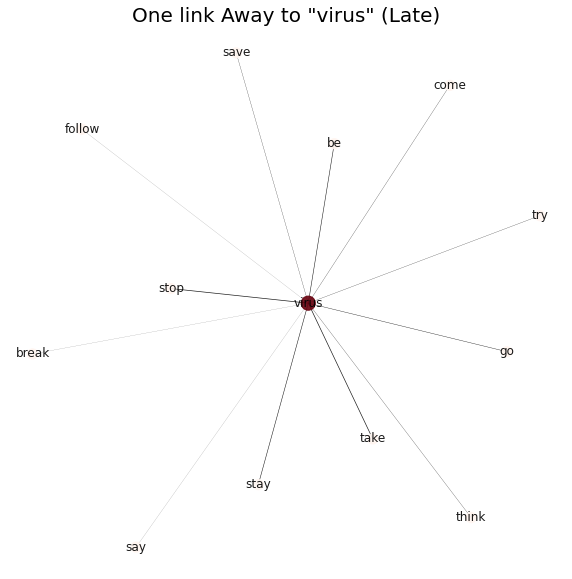

In [80]:
centralities_late_g1 = nx.closeness_centrality(g_1_late)
layout_late = nx.spring_layout(g_1_late, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_late_g1.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_1_late.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_1_late.edges(data = True)))
nx.draw(g_1_late, ax = ax, pos = layout_late, labels = {n:n for n in g_1_late.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_1_late.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_late_g1[n] / maxC for n in g_1_late.nodes],
        node_size = [centralities_late_g1[n] / maxC * 200 for n in g_1_late.nodes],
        cmap = plt.get_cmap('Reds'))
plt.title('One link Away to "virus" (Late)',size = 20)

##### Top 10 words in terms of degree centrality

In [81]:
sorted(nx.degree_centrality(g_1_late).items(), key = lambda x: x[1], reverse = True)[1:11]

[('follow', 0.08333333333333333),
 ('say', 0.08333333333333333),
 ('save', 0.08333333333333333),
 ('take', 0.08333333333333333),
 ('come', 0.08333333333333333),
 ('go', 0.08333333333333333),
 ('think', 0.08333333333333333),
 ('break', 0.08333333333333333),
 ('try', 0.08333333333333333),
 ('stay', 0.08333333333333333)]

#### Two links away

In [82]:
virus_nei_late = gNV_late.neighbors('virus')
virus_nei_late = set(virus_nei_late)
print(virus_nei_late)

{'follow', 'say', 'save', 'take', 'come', 'go', 'think', 'break', 'try', 'stay', 'stop', 'be'}


In [83]:
virus_nei_plus1_late = set(virus_nei_late)
for n in virus_nei_late:
    virus_nei_plus1_late |= set(gNV_late.neighbors(n))
gNV_virus2_late = gNV_late.subgraph(virus_nei_plus1_late)
print(nx.info(gNV_virus2_late))

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 100
Average degree:   4.4444


Text(0.5, 1.0, 'Two links Away to "virus" (Late)')

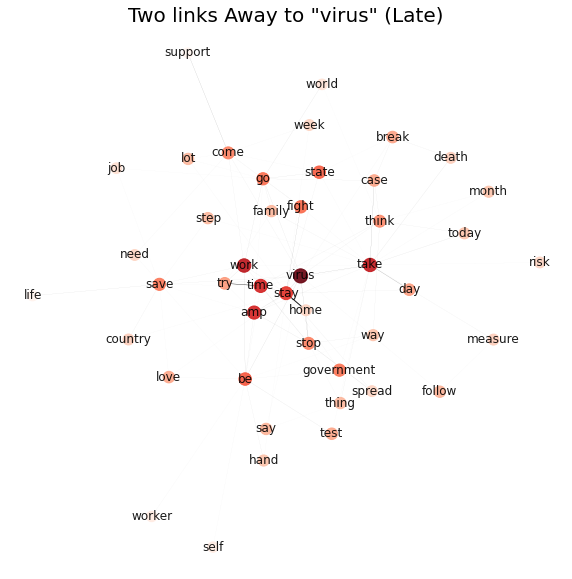

In [84]:
centralities_late_g2 = nx.closeness_centrality(gNV_virus2_late)
layout_late = nx.spring_layout(gNV_virus2_late, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_late_g2.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_virus2_late.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_virus2_late.edges(data = True)))
nx.draw(gNV_virus2_late, ax = ax, pos = layout_late, labels = {n:n for n in gNV_virus2_late.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNV_virus2_late.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_late_g2[n] / maxC for n in gNV_virus2_late.nodes],
        node_size = [centralities_late_g2[n] / maxC * 200 for n in gNV_virus2_late.nodes],
        cmap = plt.get_cmap('Reds'))
plt.title('Two links Away to "virus" (Late)',size = 20)

##### Top 10 words in terms of degree centrality

In [85]:
sorted(nx.degree_centrality(gNV_virus2_late).items(), key = lambda x: x[1], reverse = True)[1:11]

[('stay', 0.34090909090909094),
 ('virus', 0.2727272727272727),
 ('be', 0.2727272727272727),
 ('go', 0.2272727272727273),
 ('save', 0.20454545454545456),
 ('stop', 0.18181818181818182),
 ('come', 0.18181818181818182),
 ('work', 0.18181818181818182),
 ('time', 0.1590909090909091),
 ('amp', 0.1590909090909091)]

#### Three links away

In [86]:
virus_3_late = set(virus_nei_plus1_late)
for n in virus_nei_plus1_late:
    virus_3_late |= set(gNV_late.neighbors(n))
gNV_virus3_late = gNV_late.subgraph(virus_3_late)
print(nx.info(gNV_virus3_late))

Name: 
Type: Graph
Number of nodes: 67
Number of edges: 206
Average degree:   6.1493


Text(0.5, 1.0, 'Three links Away to "virus" (Late)')

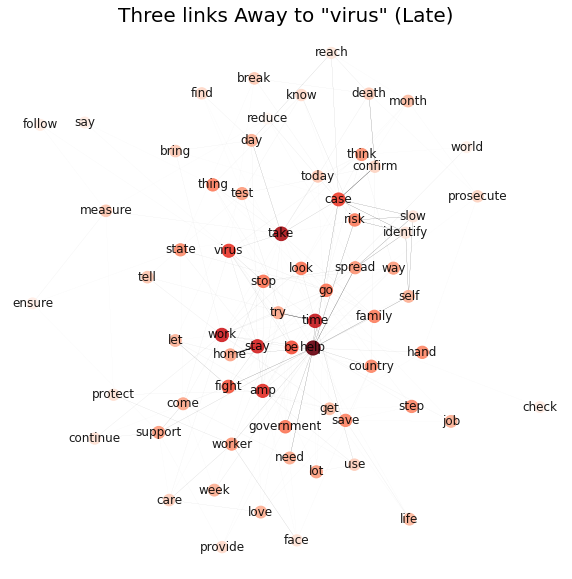

In [87]:
centralities_late_g3 = nx.closeness_centrality(gNV_virus3_late)
layout_late = nx.spring_layout(gNV_virus3_late, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_late_g3.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_virus3_late.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_virus3_late.edges(data = True)))
nx.draw(gNV_virus3_late, ax = ax, pos = layout_late, labels = {n:n for n in gNV_virus3_late.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNV_virus3_late.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_late_g3[n] / maxC for n in gNV_virus3_late.nodes],
        node_size = [centralities_late_g3[n] / maxC * 200 for n in gNV_virus3_late.nodes],
        cmap = plt.get_cmap('Reds'))
plt.title('Three links Away to "virus" (Late)',size = 20)

##### Top 10 words in terms of degree centrality

In [88]:
sorted(nx.degree_centrality(gNV_virus3_late).items(), key = lambda x: x[1], reverse = True)[1:11]

[('take', 0.2727272727272727),
 ('time', 0.24242424242424243),
 ('stay', 0.2272727272727273),
 ('work', 0.2272727272727273),
 ('amp', 0.19696969696969696),
 ('case', 0.18181818181818182),
 ('virus', 0.18181818181818182),
 ('be', 0.18181818181818182),
 ('go', 0.15151515151515152),
 ('save', 0.13636363636363635)]